# Shallow ConvNet
Architecture implemented after the description by Schirrmeister et al. (2017) in Convolutional Neural Networks in EEG Analysis (https://onlinelibrary.wiley.com/doi/10.1002/hbm.23730). Designed to mimic the FBCSP pipeline.

In [44]:
import glob
import mne
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [3]:
# Standard channel sets
CHANNELS_38 = list(range(38))
CHANNELS_19 = ["Fp1","Fp2","F3","F4","C3","C4","P3","P4","O1","O2",
                "F7","F8","T3","T4","T5","T6","Fz","Cz","Pz"]
CHANNELS_8 = ["F3","F4","C3","C4","Cz","P3","P4","Pz"]

def pick_channels(raw, n_channels=64):
    if n_channels == 64 or n_channels is None:
        return raw
    elif n_channels == 38:
        return raw.copy().pick_channels([raw.ch_names[i] for i in CHANNELS_38])
    elif n_channels == 19:
        return raw.copy().pick_channels(CHANNELS_19)
    elif n_channels == 8:
        return raw.copy().pick_channels(CHANNELS_8)

In [30]:
def process_file(file_path, T=4, n_channels=64, ds=1):
    """
    Processes one EDF file: filtering, referencing, epoching, removing T0, normalization
    """
    raw = mne.io.read_raw_edf(file_path, preload=True)
    
    # Bandpass filter 4-40 Hz
    raw.filter(4., 40., fir_design='firwin')
    
    # Channel selection
    raw = pick_channels(raw, n_channels)
    
    # Common average reference
    raw.set_eeg_reference("average")
    
    # Convert annotations to events
    event_id = {'T0':0, 'T1':1, 'T2':2}
    events, _ = mne.events_from_annotations(raw, event_id=event_id)
    
    # Epoching
    epochs = mne.Epochs(
        raw, events, event_id=event_id,
        tmin=0, tmax=T,
        baseline=None,
        preload=True
    )
    
    X = epochs.get_data()  # shape: trials × channels × samples
    
    y = epochs.events[:, -1]  # labels
    
    # Remove T0 (idle) for left vs right classification
    mask = y != 0
    X = X[mask]
    y = y[mask]
    y = y - 1  # relabel: T1 -> 0, T2 -> 1
    
    # Downsampling
    if ds > 1:
        X = X[:, :, ::ds]
    
    # Normalize per trial
    mean = X.mean(axis=-1, keepdims=True)
    std = X.std(axis=-1, keepdims=True) + 1e-6
    X = (X - mean) / std
    
    return X, y


In [41]:
all_files = glob.glob("../data/full_data/S*/S*R*.edf")
#all_files = all_files[:30]  # limit to first file for quicker testing
print(f"Found {len(all_files)} EDF files")

X_list, y_list = [], []
target_T = None
skipped_files = 0

for f in all_files:
    X, y = process_file(f, T=4, n_channels=64, ds=1)
    
    n_times = X.shape[-1]
    if target_T is None:
        target_T = n_times
        print(f"Set target_T = {target_T} from file {f}")
    else:
        if n_times > target_T:
            X = X[..., :target_T]
        elif n_times < target_T:
            skipped_files += 1
            print(f"Skipping file {f} because n_times={n_times} < target_T={target_T}")
            continue
    X_list.append(X)
    y_list.append(y)
X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)

print("Final shape:", X_all.shape, y_all.shape)
print(f"Skipped {skipped_files} files")

Found 327 EDF files
Extracting EDF parameters from E:\dev\Projects\EEG_MotorImagery_Project\data\full_data\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 265 samples (1.656 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), 

C:\Users\leona\AppData\Local\Temp\ipykernel_7028\3151710637.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7028\3151710637.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


0 projection items activated
Using data from preloaded Raw for 24 events and 513 original time points ...
0 bad epochs dropped
Skipping file ../data/full_data\S100\S100R08.edf because n_times=513 < target_T=641
Extracting EDF parameters from E:\dev\Projects\EEG_MotorImagery_Project\data\full_data\S100\S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 213 s

C:\Users\leona\AppData\Local\Temp\ipykernel_7028\3151710637.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 641 original time points ...
0 bad epochs dropped
Extracting EDF parameters from E:\dev\Projects\EEG_MotorImagery_Project\data\full_data\S101\S101R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3

In [42]:
X_tensor = torch.from_numpy(X_all).float().unsqueeze(1)
y_tensor = torch.from_numpy(y_all).long()


print(X_tensor.shape)  # should be (N, 1, 64, 640)

torch.Size([4748, 1, 64, 641])


In [45]:
full_dataset = TensorDataset(X_tensor, y_tensor)

num_samples = len(full_dataset)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=generator,
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [50]:
class Square(nn.Module):
    """x -> x^2"""
    def forward(self, x):
        return x ** 2

class SafeLog(nn.Module):
    """x -> log(x) with numerical stabilisation"""
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        return torch.log(torch.clamp(x, min=self.eps))

# Shallow ConvNet Model
class ShallowConvNet(nn.Module):
    def __init__(self, n_classes: int, n_channels: int = 64, input_time_samples: int = 640, dropout=0.5):
        """
        Parameters
        ----------
        n_classes : int
            Number of output classes.
        n_channels : int
            Number of electrodes
        input_time_samples : int
            Number of input time samples (e.g. 640 for 4 s @ 160 Hz).
        """
        super(ShallowConvNet, self).__init__()
        
        # Hyperparameters
        self.n_filters = 40
        self.n_channels = n_channels
        
        # Layers
        # Input time x electrodes (paper 534x44, we _x64)
        self.temporal_conv = nn.Conv2d(
            in_channels=1,
            out_channels=self.n_filters,
            kernel_size=(1, 16), # paper used 25 for sample rate 250 -> we use 16 for sample rate 160?
            bias=False
        ) # 40 Units temporal conv
        
        self.spatial_filter = nn.Conv2d(
            in_channels=self.n_filters,
            out_channels=self.n_filters,
            kernel_size=(self.n_channels, 1),
            groups=self.n_filters,
            bias=False # arl disables bias
        ) # 40 Units spatial filter (conv)
        
        self.bn = nn.BatchNorm2d(self.n_filters)
        
        self.square = Square() # Squaring Non-linearity
        self.mean_pooling = nn.AvgPool2d(kernel_size=(1, 48), stride=(1, 9)) # 75x1 kernel Mean Pooling w. 15 x 1 stride -> 48, 1 and 9, 1 (or 10, 1?). Only AvgPooling available.
        self.log_activation = SafeLog() # Log activation
        
        # Arl adds dropout layer
        self.dropout = nn.Dropout(dropout)
        
        n_features = self._get_flatten_size(input_time_samples)
        self.dense = nn.Linear(n_features, n_classes) # Linear classification
        #self.softmax = nn.Softmax(dim=1) # softmax

    def _get_flatten_size(self, input_time):
        with torch.no_grad():
            x = torch.zeros(1, 1, self.n_channels, input_time)
            x = self.temporal_conv(x)
            x = self.spatial_filter(x)
            x = self.mean_pooling(x)
            return x.flatten().shape[0]

    def forward(self, x):
        out = self.temporal_conv(x)
        out = self.spatial_filter(out)
        out = self.bn(out)
        out = self.square(out)
        out = self.mean_pooling(out)
        out = self.log_activation(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        #out = self.softmax(out)
        return out

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [52]:
model = ShallowConvNet(n_channels=64, n_classes=2, input_time_samples=X_tensor.shape[-1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

# ======== Initialize lists to store metrics ========
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # ======== Training ========
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, preds = outputs.max(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # ======== Validation ========
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

Epoch 1/100: Train Loss=0.7134, Train Acc=0.5661, Val Loss=0.6215, Val Acc=0.6540
Epoch 2/100: Train Loss=0.5890, Train Acc=0.6856, Val Loss=0.5562, Val Acc=0.7257
Epoch 3/100: Train Loss=0.5334, Train Acc=0.7285, Val Loss=0.5351, Val Acc=0.7321
Epoch 4/100: Train Loss=0.4902, Train Acc=0.7575, Val Loss=0.5759, Val Acc=0.7236
Epoch 5/100: Train Loss=0.4566, Train Acc=0.7809, Val Loss=0.5114, Val Acc=0.7532
Epoch 6/100: Train Loss=0.4358, Train Acc=0.7994, Val Loss=0.5021, Val Acc=0.7616
Epoch 7/100: Train Loss=0.4141, Train Acc=0.8096, Val Loss=0.5173, Val Acc=0.7616
Epoch 8/100: Train Loss=0.4092, Train Acc=0.8154, Val Loss=0.5219, Val Acc=0.7511
Epoch 9/100: Train Loss=0.3963, Train Acc=0.8123, Val Loss=0.4721, Val Acc=0.7827
Epoch 10/100: Train Loss=0.3656, Train Acc=0.8378, Val Loss=0.4585, Val Acc=0.7869
Epoch 11/100: Train Loss=0.3779, Train Acc=0.8331, Val Loss=0.4580, Val Acc=0.7869
Epoch 12/100: Train Loss=0.3478, Train Acc=0.8476, Val Loss=0.5301, Val Acc=0.7785
Epoch 13/100:

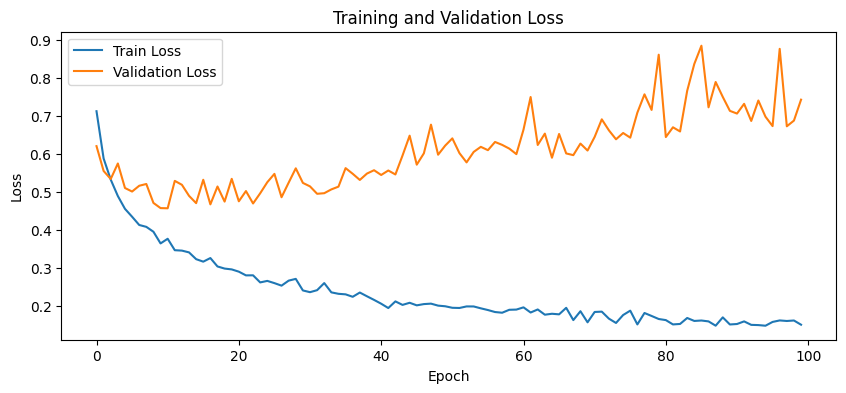

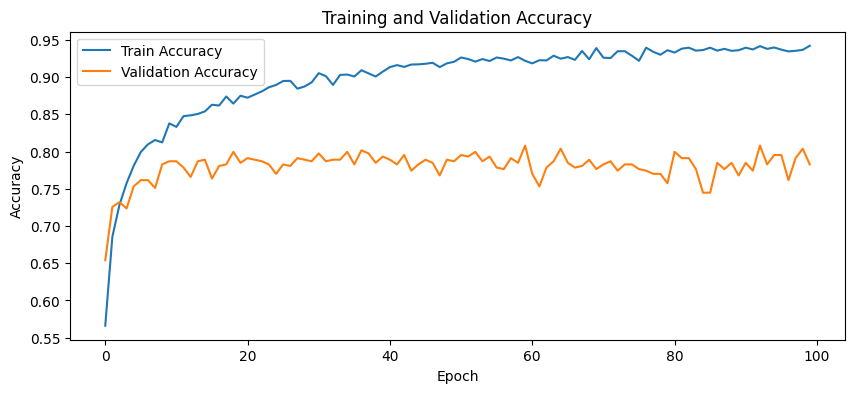

In [53]:
import matplotlib.pyplot as plt

# ======== Loss Curve ========
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# ======== Accuracy Curve ========
plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()